<a href="https://colab.research.google.com/github/stat10/DS10-Projects/blob/main/DS10_2021_Wine_Classification_Part_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a id='top'></a>
# DS10 Wine Classification - Part 2
Notebook by Rashmi Banthia and Hanspeter Pfister

**Make a copy of this notebook before you make any edits.** Add your name and the name of your team and team members in the text cell below. Answer all of the questions inside the notebook using text and code. Add your answers after the **A** in the text cells. Each team will only submit one notebook. 

In addition to submitting the completed notebook, each team will also submit a PDF with plots and solutions to some of the exercises below. Check the project instructions on Canvas for submission information.

This notebook covers the following topics:

- Logistic regression, decision tree, SVM, and kNN models 
- Model Performance Assessment 
     - Accuracy Score
     - Confusion Matrix
     - ROC Curve and AUC Score
     - Precision-Recall Curve
     - F1 Score
- Cross-Validation and Grid Search
     - SVM - find optimal kernel and parameter C
     - kNN - find optimal k
     - Decision Tree - find optimal tree depth
     - Effects of Optimal Hyperparameters
- Advanced Topics
     - Feature Importance (Decision Tree Example)
     - Visualizing Decision Boundaries
     - Balanced vs. Imbalanced Data
     - Dealing with Imbalanced Data

**Note: The exercises for Effects of Optimal Hyperparameters, Visualizing Decision Boundaries, and Balanced vs. Imbalanced Data at the end will take some time, so please get started early!**


--------
**Team Name:**

**Team Members:**

--------

In [ ]:
# Pandas is a powerful package that deals with tables (https://pandas.pydata.org)
# You will get a proper introduction to Pandas in the labs.
import pandas as pd
# Of course we will be using Numpy
import numpy as np

# We are using scikit-learn for machine learning (https://scikit-learn.org/stable/)
# Because scikit-learn is a big package it is good practice to only import the modules we need.
from sklearn.tree import DecisionTreeClassifier
import graphviz 
from sklearn.tree import export_graphviz

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import accuracy_score, precision_score,  recall_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 

# We will be using statsmodels for linear regression (https://www.statsmodels.org/stable/index.html) 
import statsmodels.api as sm
from statsmodels import graphics

# Some useful libraries to import data
import requests
from urllib.request import urlopen
from io import BytesIO
from zipfile import ZipFile

# Libraries for visualizations
from matplotlib import pyplot as plt
import seaborn as sns
# Some settings to make the plots prettier
%matplotlib inline
sns.set_theme(style="ticks")
sns.set_context("talk", font_scale=0.9)
sns.set(font_scale = 1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Getting the Data

In [ ]:
# Reading the dataset into a Pandas dataframe (df)
df = pd.read_csv('https://raw.githubusercontent.com/hpfister/ds10/master/winequality-red.csv', sep=';')
# 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv' # Alternate URL
print(df.shape) # we have 1599 rows and 12 columns
df.head()

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Predicted Value

Our target predicted value is `quality`, which is a discrete ordinal value in the range (3, 8). First, lets take a look at the number of wines for each quality level in the dataset. 

In [ ]:
# Our target Predicted value is quality 
print(df.quality.value_counts())

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64


------
### Binary Classification

We are going to convert this into a binary classification problem. I.e., we will convert the ordinal values of `quality` into a binary class (0, 1) (0 = bad quality, 1 = good quality). 

We decide that wines with quality `>=6` are good quality (i.e., `quality=1`) and wines with quality `<6` are bad quality (i.e., `quality=0`). Later on you will change this threshold to create an imbalanced dataset. For now, pay attention to where it says "COME BACK HERE" in the code. 

In [ ]:
# By convention, the perdictor are stored in the vector Y
Y = df.quality

# By convention, the features are stored in the vector X
X = df[df.columns.difference(['quality'])]
print(X.shape, Y.shape)

# Original code - leave this for your first run through
# Convert Y to a vector with binary values. Ratings 6,7,8 are good quality, <6 are bad quality
Y = np.array([1 if y>=6 else 0 for y in Y])

# COME BACK HERE: Later on, you will change the ratings threshold to get an imbalanced dataset 
# Imbalanced: Ratings 7,8 are good quality,  3,4,5,6 are bad quality - comment line 10 and uncomment line 14
# Y = np.array([1 if y>=7 else 0 for y in Y])

# Print the percentage of samples in each class
print("\n\nBinary Classification (1 = Good quality  , 0 = Bad quality): ")
print(pd.Series(Y).value_counts(normalize=True))  

(1599, 11) (1599,)


Binary Classification (1 = Good quality  , 0 = Bad quality): 
1    0.534709
0    0.465291
dtype: float64


# Basic ML Models

We are training the same basic ML models we used in part 1:
- Logistic regression
- SVM
- Decision Tree
- k-Nearest Neighbor (kNN)

We will first create our training and test data and then standardize the data. 

In a binary classification problem, we may decide to predict the class values (0 or 1) for each wine directly. However, it is more flexible to predict the probabilities for each class instead. The reason for this is to provide the capability to choose and even calibrate a **threshold** for how to interpret the predicted probabilities. 

For example, a threshold of 0.5 means that a probability in [0.0, 0.49] is a negative outcome (0=bad quality) and a probability in [0.5, 1.0] is a positive outcome (1=good quality). This threshold can be adjusted to tune the behavior of the model for a specific problem. An example would be to reduce more of one or another type of error.

In the following code, we are making sure that all our models output probabilities for each class. We will then compute confusion matrices and then adjust the threshold to compute ROC/AUC and precision / recall curves.

**Split and Standardize Data**

In [ ]:
# From Part 1 
# Split data into train (80%) and test (20%) sets.
# random_state: Controls the shuffling applied to the data before applying the split. 
#              Pass an int for reproducible output across multiple function calls.
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.2,
                                                    random_state=10)


# Standardize the features

# We standardize training and test data separately to avoid information leakage between them
# Also note we do not standardize the predicted value `quality`, just the features
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# sklearn StandardScaler() returns Numpy arrays. That means your column names are gone. 
# If we want to preserve the column names we need to convert the array back to a Pandas dataframe and add the column names. 
X_train_s = pd.DataFrame(X_train_s,columns=X.columns)
X_test_s = pd.DataFrame(X_test_s,columns=X.columns)

**Logistic Regression**

In [ ]:
# From Part 1 
# Creating the logistic regression model
# Hyperparamter 'C' controls how much regularization the model uses (smaller C = more regularization)
lr_clf = LogisticRegression(solver='liblinear', 
                           random_state=57,C=10000) 

# Fitting the model to the data (i.e., training the model)
lr_clf.fit(X_train_s, y_train)

# Predictions on the test set
lr_preds = lr_clf.predict(X_test_s)

# Predict probabilities on the test set
# Predicted probabilites are required for plotting ROC AUC curve
lr_preds_prob = lr_clf.predict_proba(X_test_s)


**Support Vector Machine**

In [ ]:
# From Part 1
# Creating the SVM model
# We are setting probability=True for the model to predict probabilites (this was not in part 1)
# Note the hyperparameters 'kernel' and 'C' (smaller C = more regularization) - we will come back to these later
# INITIAL CODE
svc_clf = SVC( kernel='rbf', C=100.0, probability=True, random_state=10) 
# OPTIMAL HYPERPARAMETERS
# Change your optimal parameters here after you finished the "Cross-Validation and Grid Search" section.
# svc_clf = SVC( kernel='rbf', C=100.0, probability=True, random_state=10)

# Fitting the model to the data (i.e., training the model)
svc_clf.fit(X_train_s, y_train) 

# Predictions on the test set
svc_preds = svc_clf.predict(X_test_s)

# Predict probabilities on the test set
# Predicted probabilites are required for plotting ROC AUC curve
svc_preds_prob = svc_clf.predict_proba(X_test_s)

**Decision Tree** 

In [ ]:
# From Part 1 
# Creating the DT model
# Note the hyperparameter 'max_depth' - we will come back to this later
# INITIAL CODE
clf_dt = DecisionTreeClassifier(max_depth=10, random_state=10) 
# OPTIMAL HYPERPARAMETERS
# Change your optimal parameters here after you finished the "Cross-Validation and Grid Search" section.
# clf_dt = DecisionTreeClassifier(max_depth=10, random_state=10) 

# Fitting the model to the data (i.e., training the model)
clf_dt.fit(X_train_s, y_train)

# Predictions on the test set
dt_preds = clf_dt.predict(X_test_s)

# Predict probabilities on the test set
# Predicted probabilites are required for plotting ROC AUC curve
dt_preds_prob = clf_dt.predict_proba(X_test_s)


**KNearest Neighbors**

In [ ]:
# From Part 1 
# Creating the KNN model
# Note the hyperparameter 'n_neighbors' (or k) and p - we will come back to this later
# INITIAL CODE
clf_knn = KNeighborsClassifier(n_neighbors=10, p=2)
# OPTIMAL HYPERPARAMETERS
# Change your optimal parameters here after you finished the "Cross-Validation and Grid Search" section.
# clf_knn = KNeighborsClassifier(n_neighbors=10, p=2)

# Fitting the model to the data (i.e., training the model)
clf_knn.fit(X_train_s, y_train)

# Predictions on the test set
knn_preds = clf_knn.predict(X_test_s)

# Predict probabilities on the test set
# Predicted probabilites are required for plotting ROC AUC curve
knn_preds_prob = clf_knn.predict_proba(X_test_s)

# Model Performance Assessment

We will now compare several error metrics to assess the performance of our classification models. Please take note and capture screenshots of the visualizations. Later on you will come back to re-run these cells with an imbalanced dataset, and we would like you to compare the results of the balanced and imbalanced data. 

## [Accuracy](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

The most commonly used metric to judge a model is accuracy. Unfortunately, accuracy is a bad indicator of model performance, especially when the classes are imbalanced. 

In [ ]:
# Setting different colors for the print statements
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'


# We evaluate each model on the test set with accuracy
print(color.BOLD + '\nLogistic Regression: ') 
print("Accuracy:", accuracy_score(y_test,lr_preds))

print(color.BLUE + '\nSupport Vector Machine: ')
print("Accuracy:", accuracy_score(y_test,svc_preds))


print(color.RED + '\nDecision Tree: ')
print("Accuracy:", accuracy_score(y_test,dt_preds))

print(color.PURPLE + '\nKNearest Neighbors: ')
print("Accuracy:", accuracy_score(y_test,knn_preds))



Logistic Regression: 
Accuracy: 0.73125

Support Vector Machine: 
Accuracy: 0.7375

Decision Tree: 
Accuracy: 0.778125

KNearest Neighbors: 
Accuracy: 0.71875


**Q** We said that accuracy is a bad metric for imbalanced data. For example, the chances of having cancer are very low. Let’s say 90 out of 100 patients do not have cancer and the remaining 10 actually have it. What simple, but useless model would get 90% accuracy for this data?

**A** 

## [Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)
The confusion matrix nicely summarizes the following quantities:

- True positives (TP): Predicted positive and are actually positive.
- False positives (FP): Predicted positive and are actually negative.
- True negatives (TN): Predicted negative and are actually negative.
- False negatives (FN): Predicted negative and are actually positive.

See [Wikipedia](#https://en.wikipedia.org/wiki/Confusion_matrix) for a good explanation and a nice figure on how the confusion matrix relates to the different error metrics.

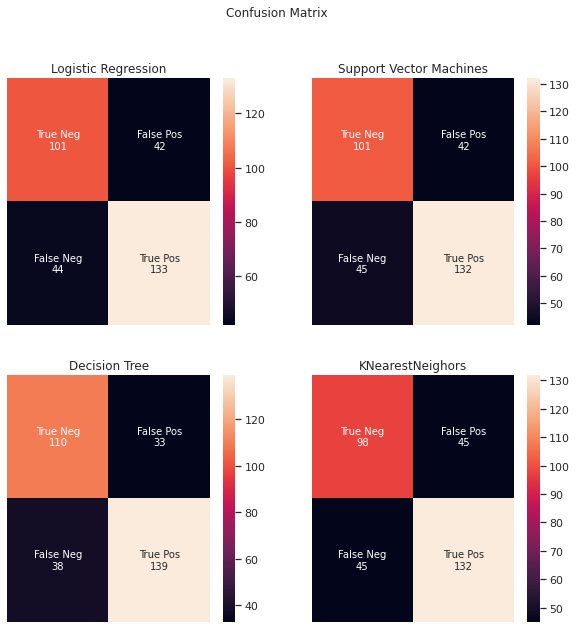

In [ ]:
# CAREFUL: scikit-learn plots the confusion matrix with TP in the lower right corner unlike 
# what would be considered the "standard" arrangement with TP in the upper left corner. 
# Alway check the axis in the confusion matrix plot!

fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Confusion Matrix')
# remove the x and y ticks
plt.setp(axs, xticks=[], yticks=[])
threshold = 0.5
group_names = ['True Neg','False Pos','False Neg','True Pos']

all_preds = [lr_preds_prob, svc_preds_prob, dt_preds_prob, knn_preds_prob]
titles = ['Logistic Regression', 'Support Vector Machines', 'Decision Tree', 'KNearestNeighors']

for i in range(2):
    for j in range(2):
        cf_matrix =  confusion_matrix(y_test, all_preds[i*2+j][:,1]>threshold) 
        group_counts = [value for value in  cf_matrix.flatten()]
        labels = [f"{v1}\n{v2}" for v1, v2 in  zip(group_names,group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        axs[i,j].title.set_text(titles[i*2+j])
        sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axs[i,j])


plt.setp(axs, xticks=[], yticks=[]); #Remove x and y tick labels

**Q** Looking at these confusion matrices, rank the models by performance, and explain your ranking. 

**A** 

---
**Q** Looking at the SVM confusion matrix, how would you feel about this model if this were a medical diagnosis example (0 = disease not present, 1 = disease present)? 

**A** 

## [ROC Curve and AUC Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html?highlight=roc_curve#sklearn.metrics.roc_curve)

The ROC (Receiver Operator Characteristics) curve shows the TPR (true positive rate) and FPR (false positive rate) for a number of different threshold values to convert class probabilites to binary classification outputs. Put another way, it plots the false alarm rate (FPR) versus the hit rate (TPR).

The true positive rate is calculated as the number of true positives divided by the sum of the number of true positives and the number of false negatives. It describes how good the model is at predicting the positive class when the actual outcome is positive.

**True Positive Rate = True Positives / (True Positives + False Negatives)**

The false positive rate is calculated as the number of false positives divided by the sum of the number of false positives and the number of true negatives. It is also called the false alarm rate as it summarizes how often a positive class is predicted when the actual outcome is negative.

**False Positive Rate = False Positives / (False Positives + True Negatives) = 1 - Specificity**

The diagonal line indicates random chance results for all thresholds. The Area Under Curve (AUC) metric computes the area under the ROC curve. The higher the AUC score, the better. It is a better metric than accuracy in case of class imbalance. 

[Source](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

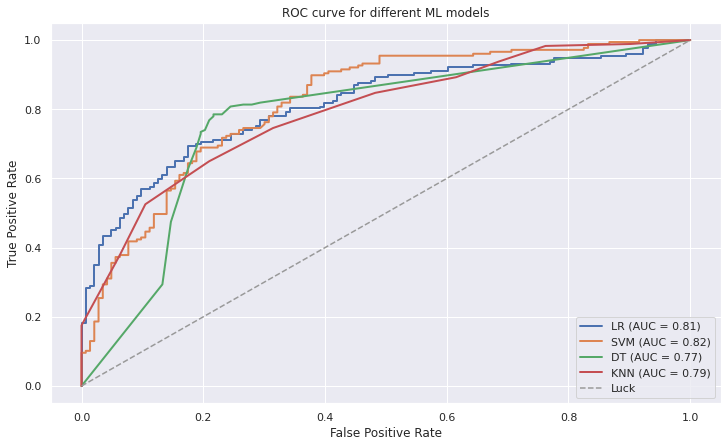

In [ ]:
# Compare all classifiers (Logisitic Regression, SVM, Decision Tree and KNN) with ROC curves and AUC
plt.figure(figsize=(12,7))
labels = ['LR', 'SVM', 'DT', 'KNN']
all_preds = [lr_preds_prob, svc_preds_prob, dt_preds_prob, knn_preds_prob]

# For all four models:
for i in range(4):
    # The roc_curve() function takes both the true outcomes (0,1) from the test set and 
    # the predicted probabilities for the 1 class. The function returns the false positive 
    # rates for each threshold, true positive rates for each threshold, and the thresholds.
    fpr, tpr, roc_thresholds = roc_curve(y_test,all_preds[i][:,1])
    
    # The auc() function computes the AUC
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label='%s (AUC = %0.2f)' % (labels[i], roc_auc))

# Diagonal line for chance predictions
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck'); 

# Show a bit beyond range [0,1]
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])

# Axis labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for different ML models')
plt.legend(loc="lower right")

# Show the plot
plt.show()


**Q** What do you notice? What do you wonder?

**A** 

-----
**Q** Looking at the ROC curve for the SVM model, what values are a desirable balance between the false positives and false negatives? Report the (TPR, FPR) values for the optimal point on the ROC curve and explain your reasoning. 

**A** 

-----
**Q** Are the class predictions that gets passed to `roc_curve()` discrete or continuous? 

**A** 

## [Precision-Recall Curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html)

A precision-recall curve is a plot of the precision (y-axis) and the recall (x-axis) for different thresholds, much like the ROC curve. 

Precision is a ratio of the number of true positives divided by the sum of the true positives and false positives. It describes how good a model is at predicting the positive class. Precision is also referred to as the positive predictive value (PPV).

**Precision = True Positives / (True Positives + False Positives) = PPV **

Recall is calculated as the ratio of the number of true positives divided by the sum of the true positives and the false negatives. Recall is the same as sensitivity.

**Recall = True Positives / (True Positives + False Negatives) = Sensitivity**

Reviewing both precision and recall is useful in cases where there is an imbalance in the observations between the two classes. Specifically, if there are many examples of no event (class 0) and only a few examples of an event (class 1). 

Typically, the large number of class 0 examples (i.e., high true negatives) means we are less interested in the skill of the model at predicting class 0 correctly. [Precision and recall are better for imbalanced data](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0118432) because the calculations do not make use of the true negatives (class 0) and are only concerned with the correct prediction of the minority class (class 1).

A no-skill classifier is one that cannot discriminate between the classes and would predict a random class or a constant class in all cases. The no-skill line is a horizontal line that changes based on the value of the ratio of positive to negative cases in the dataset. For a balanced dataset this is line is at y=0.5.

A model with perfect skill is depicted as a point at (1,1). A skilful model is represented by a curve that bows towards (1,1) above the flat line of no skill. The AUC summarizes the integral or an approximation of the area under the precision-recall curve across thresholds like the ROC AUC.

[Source](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

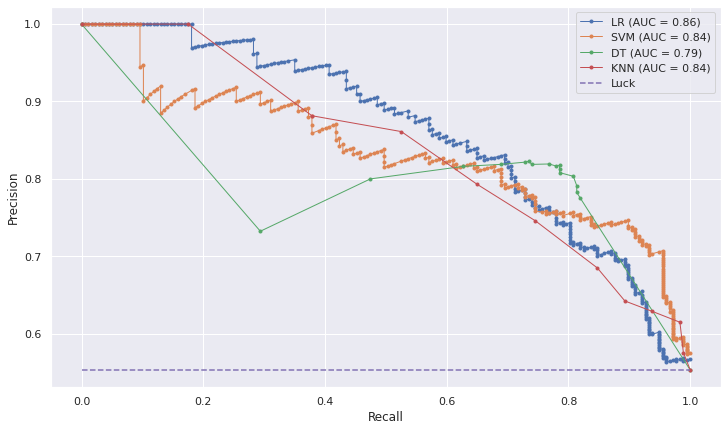

In [ ]:
# Compare all classifiers (Logisitic Regression, SVM, Decision Tree and KNN) with P-R curves and AUC
plt.figure(figsize=(12,7))
all_preds = [lr_preds_prob, svc_preds_prob, dt_preds_prob, knn_preds_prob]
labels = ['LR', 'SVM', 'DT', 'KNN']

# For all four models:
for i in range(4):
    # The precision_recall_curve() function takes the true output values and
    # the probabilities for the positive class as input and returns the precision, 
    # recall and threshold values.
    prec, rec, pr_thresholds = precision_recall_curve(y_test, all_preds[i][:,1])

    # The auc() function computes the AUC
    auc_prec_rec = auc(rec, prec)
    plt.plot(rec, prec, marker='.', lw=1, label='%s (AUC = %0.2f)' % (labels[i], auc_prec_rec)); 
    

# Plot chance prediction precision-recall curve
chance = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [chance, chance], linestyle='--', label='Luck')

# Axis labels & legend
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# Show the plot
plt.show()


**Q** What do you notice? What do you wonder? 

**A** 

## Predicted Probabilites

It is instructive to look at the predicted probabilites of each model, and to see how many unique values there are. Below is code for showing the probabilities of the positive predictions (class 1) and the number of unique probabilities for each of the models.

In [ ]:
lr_preds_prob[:,1]

array([0.55308679, 0.24002594, 0.52553567, 0.63524837, 0.34235874,
       0.90289527, 0.85063011, 0.6637669 , 0.25577538, 0.08576731,
       0.91225146, 0.33432062, 0.24333971, 0.09385271, 0.27194321,
       0.26140051, 0.44799396, 0.64865857, 0.35256899, 0.05364075,
       0.21541474, 0.86056089, 0.54086242, 0.44086159, 0.13684722,
       0.64285193, 0.79679167, 0.48976519, 0.66298757, 0.34675611,
       0.19680862, 0.36156288, 0.80838758, 0.88764206, 0.88019086,
       0.27816864, 0.95151553, 0.40326716, 0.74786245, 0.20147156,
       0.81265537, 0.80998061, 0.28469746, 0.94339276, 0.0382497 ,
       0.85063011, 0.51303393, 0.70443295, 0.97658508, 0.50813153,
       0.67956188, 0.96999508, 0.94803227, 0.90953897, 0.48032469,
       0.97039192, 0.62547629, 0.00757758, 0.46300733, 0.39733374,
       0.74294894, 0.1880337 , 0.91801125, 0.63399926, 0.45251334,
       0.29325931, 0.53789136, 0.62671656, 0.33142107, 0.71401779,
       0.78471729, 0.1786226 , 0.50438521, 0.36554751, 0.40513

In [ ]:
svc_preds_prob[:,1]

array([0.77621189, 0.22937074, 0.5       , 0.75807025, 0.66386947,
       0.86888307, 0.88087767, 0.7937282 , 0.6918607 , 0.10008513,
       0.66798612, 0.28736769, 0.3815453 , 0.2879819 , 0.54804646,
       0.36679735, 0.3790928 , 0.69045392, 0.69047262, 0.03918644,
       0.30921262, 0.8176574 , 0.72658849, 0.0566502 , 0.29129597,
       0.83005601, 0.33953239, 0.36366478, 0.66176613, 0.32865191,
       0.3413597 , 0.46132235, 0.95829638, 0.94628987, 0.80432669,
       0.27853274, 0.84880898, 0.4698479 , 0.88633523, 0.38808812,
       0.71166824, 0.80271403, 0.38455604, 0.68437824, 0.00443843,
       0.88087767, 0.79223741, 0.69042655, 0.60946945, 0.76700563,
       0.73347976, 0.93319117, 0.99483883, 0.72528681, 0.55939717,
       0.93353185, 0.23768428, 0.0276228 , 0.34070997, 0.42439626,
       0.31525731, 0.42071471, 0.94249716, 0.61207769, 0.66340217,
       0.52991424, 0.67619421, 0.70490339, 0.29778759, 0.45796331,
       0.23890783, 0.29381787, 0.21577431, 0.40738086, 0.45744

In [ ]:
dt_preds_prob[:,1] 

array([0.93103448, 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.96511628, 0.95384615, 0.        , 0.        ,
       0.96511628, 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.93103448, 1.        , 0.        ,
       0.        , 0.8       , 1.        , 0.        , 0.        ,
       0.5       , 0.        , 1.        , 1.        , 0.        ,
       0.        , 0.        , 0.96511628, 0.98601399, 0.98601399,
       0.        , 0.98601399, 0.        , 1.        , 0.625     ,
       0.96511628, 0.96511628, 0.        , 1.        , 0.        ,
       0.96511628, 1.        , 1.        , 1.        , 0.        ,
       0.5       , 0.8       , 0.98601399, 0.96511628, 1.        ,
       1.        , 0.96511628, 0.        , 0.        , 1.        ,
       1.        , 0.        , 0.98601399, 0.28571429, 1.        ,
       0.        , 0.5       , 1.        , 1.        , 0.96511628,
       1.        , 0.        , 0.        , 0.        , 0.63636

In [ ]:
knn_preds_prob[:,1]

array([0.9, 0.1, 0.7, 0.8, 0.5, 0.9, 1. , 1. , 0.6, 0. , 0.9, 0.6, 0. ,
       0.2, 0.7, 0.4, 0.5, 0.8, 0.2, 0.1, 0.5, 0.9, 0.8, 0.3, 0.4, 0.9,
       0.8, 0.5, 0.8, 0.4, 0. , 0.5, 0.9, 0.9, 0.9, 0.1, 1. , 0.5, 0.9,
       0.2, 0.9, 0.9, 0.3, 0.9, 0. , 1. , 0.6, 0.9, 1. , 0.7, 0.6, 1. ,
       0.9, 0.9, 0.8, 0.9, 0.1, 0. , 0.5, 0.3, 0.7, 0.1, 1. , 0.7, 0.2,
       0.4, 0.8, 0.7, 0.3, 0.8, 0.3, 0.2, 0.4, 0.5, 0.5, 0.1, 0.7, 0.7,
       0.7, 0.9, 1. , 0.1, 0.8, 0.1, 0.8, 0.9, 0.5, 0.1, 0.5, 0.5, 0.8,
       0.7, 0.9, 0.5, 0.5, 0.6, 0.4, 0.2, 0.8, 0.9, 0.9, 0.6, 0.3, 0.6,
       0.8, 0.7, 0.3, 0.6, 0.9, 0.8, 0.5, 1. , 0.8, 0.5, 0.4, 0.4, 0.2,
       0. , 0.9, 0.8, 0.5, 0.1, 0.8, 0.5, 0.6, 0.7, 0.6, 0.5, 0.2, 0.2,
       0.7, 0.1, 0.6, 0.5, 0.5, 1. , 0.9, 0.5, 0. , 0.8, 0.8, 0.9, 0.5,
       0.6, 0.7, 0.9, 0.4, 0.4, 0. , 0.5, 0.5, 0.8, 0.5, 0.9, 0.7, 0.4,
       0.5, 0.1, 0.7, 0.7, 0.6, 0.9, 1. , 0.7, 0.6, 0.3, 1. , 1. , 0.5,
       0.9, 0.1, 0.9, 0.6, 1. , 0.9, 0.4, 0.5, 0.7, 0.1, 1. , 0.

In [ ]:
# Here is the number of unique positive predictions (class 1)
print(color.BOLD + 'Number of elements in the positive class (class 1): ') 

print(color.BOLD + '\nLogistic Regression: ') 
print("count:", np.unique( lr_preds_prob[:,1]).shape) 

print(color.BLUE + '\nSupport Vector Machine: ')
print("count:", np.unique( svc_preds_prob[:,1]).shape) 

print(color.RED + '\nDecision Tree: ')
print("count:", np.unique( dt_preds_prob[:,1]).shape) 

print(color.PURPLE + '\nKNearest Neighbors: ')
print("count:", np.unique( knn_preds_prob[:,1]).shape)

Number of elements in the positive class (class 1): 

Logistic Regression: 
count: (313,)

Support Vector Machine: 
count: (311,)

Decision Tree: 
count: (17,)

KNearest Neighbors: 
count: (11,)


-----
**Q** What do you notice? Would this explain something you might have wondered about in the ROC and P-R plots?

**A** 

## [F1 Score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html?highlight=f1_score#sklearn.metrics.f1_score)
There are also composite scores that attempt to summarize the precision and recall; the most notable example is the F-measure or F1 score. It calculates the weighted average of precision and recall for a specific probability threshold (e.g. 0.5):

**F1 = 2 x (Precision x Recall) / (Precision + Recall)**

In the multi-class and multi-label case, we compute the average of the F1 score of each class with weighting depending on the `average` parameter.

F1 Score is a good measure to use to seek a balance between precision and recall, especially if there is an uneven class distribution (e.g., large number of negatives).

[Source](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [ ]:
# Printing F-1 scores for the different models
print(color.BOLD + '\nLogistic Regression: ') 
print("F1-Score: {0:0.5f}".format(f1_score(y_test,lr_preds)))

print(color.BLUE + '\nSupport Vector Machine: ')
print("F1-Score: {0:0.5f}".format(f1_score(y_test,svc_preds)))

print(color.RED + '\nDecision Tree: ')
print("F1-Score: {0:0.5f}".format(f1_score(y_test,dt_preds)))

print(color.PURPLE + '\nKNearest Neighbors: ')
print("F1-Score: {0:0.5f}".format(f1_score(y_test,knn_preds)) + color.END)



Logistic Regression: 
F1-Score: 0.75568

Support Vector Machine: 
F1-Score: 0.75862

Decision Tree: 
F1-Score: 0.79656

KNearest Neighbors: 
F1-Score: 0.74576


---
**Q** How do the F1 scores compare with what you noticed before about the ROC and P-R curves? How do they compare with the accuracy scores? Does this change your mind about which model is best?

**A** 

# [Cross-Validation and Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

A model **hyperparameter** is a characteristic of a model that is external to the model and whose value cannot be estimated from data. The value of the hyperparameter has to be set before the learning process begins. For example, C in Support Vector Machines, k in k-Nearest Neighbors, the depth of the tree for decision trees, etc.

We can use cross-validation and grid search to find the optimal hyperparameters of a model which results in the most ‘accurate’ predictions. Grid search builds a model for every combination of the hyperparameters we specify and evaluates each model. The grid search provided by GridSearchCV() exhaustively generates candidates from a grid of parameter values specified with the `param_grid` parameter. 

Remember that in Part 1 we had split the data into training and test sets using an 80% / 20% split. For cross validation, we will use the full datasets again, i.e., `X` for the features and `Y` for the predicted binary variable `quality`.

## [Support Vector Machine](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)

As you know from Chapter 3 in the ML book and the lecture video (on Canvas), SVMs have two important hyperparamters. One is the **kernel** that we apply to the data to deal with non-linear decision boundaries. Popular choices are `linear` to use a linear hpyerplane as the decision boundary and `rbf` to transform the data using a [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel). 

The hyperparameter **C** determines the tradeoff between increasing the size of the decision boundary (i.e., its margin) and making sure each examples is classified correctly (accuracy). C is a *regularization* parameter, where the strength of the regularization is inversely proportional to C. **Regularization** is an umbrella term that encompasses methods that force the learning algorithm to build a less complex model. In practice, that oftern leads to slighly higher bias but significantly reduces the variance. 

We are now going to use using grid search to find optimal values for `kernel` and `C`. 


In [ ]:
# We search over SVM kernels (linear or RBF) and values of C (1, 10, or 100).
param_grid = {'kernel':('linear', 'rbf'), 'C':[1, 10, 100]}

# Defining our model
svc = SVC()

# Initializing grid search
clf = GridSearchCV(svc, param_grid, n_jobs=-1 ) # n_jobs=-1 will utilize all the processors

# Fitting the model to the full feature data X and predicted variable Y
# Note: the grid search is actually run when you call GridSearchCV.fit()
clf.fit(StandardScaler().fit_transform(X), Y);


**Q** Read [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and find out what type of cross validation strategy GridSearchCV() uses. 

**A** 

In [ ]:
# Gather grid search information stored in `clf.cv_results_` into a dataframe
grid_df = pd.DataFrame(clf.cv_results_['params'])
grid_df['mean_test_score'] = clf.cv_results_['mean_test_score']
grid_df['plot_label'] = 'C:' + grid_df.C.astype('str') + ' Kernel: ' + grid_df.kernel
grid_df = grid_df.sort_values('mean_test_score')
# Display the dataframe
grid_df

,C,kernel,mean_test_score,plot_label
5,100,rbf,0.668527,C:100 Kernel: rbf
3,10,rbf,0.717951,C:10 Kernel: rbf
4,100,linear,0.719212,C:100 Kernel: linear
2,10,linear,0.720462,C:10 Kernel: linear
0,1,linear,0.721087,C:1 Kernel: linear
1,1,rbf,0.737332,C:1 Kernel: rbf


**Q** Look at the documentation of the results returned in `cv_results_` by [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and do some internet sleuthing (e.g., on [StackOverflow](https://stackoverflow.com/), a great community forum for programmers). How exactly is `mean_test_score` computed, and what other information does `cv_results_` provide?

**A** 

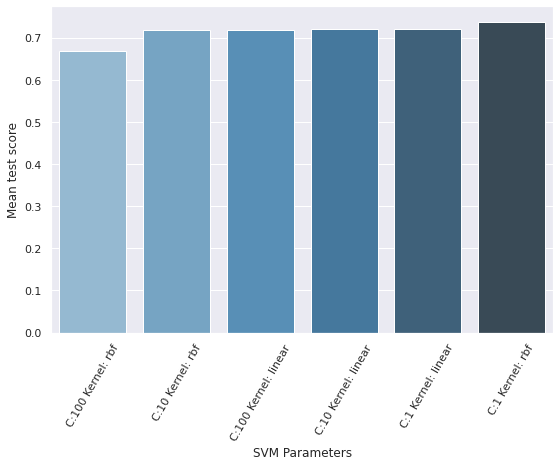

In [ ]:
# Let's display the mean test scores as a bar chart
fig, ax = plt.subplots(figsize=(9,6))
p = sns.barplot(x='plot_label', y='mean_test_score', data=grid_df,ax=ax, palette="Blues_d")
p.set_xticklabels(labels=grid_df.plot_label,rotation=60);
p.set_xlabel("SVM Parameters");
p.set_ylabel("Mean test score"); # Notice the semicolon, this avoids extraneous output

**Q** What do you notice? What do you wonder? What are the optimal SVM hyperparameters for this data?

**A** 

### KNN

As you know from Chapter 3 in the ML book and the lecture video (on Canvas), KNN also has two important hyperparamters. The first one is the value of **k**, the number of nearest neighbors for each example in the test data. The second is the **distance metric** that we use to find the k-nearest neighbors. There are [many choices](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html) for distance metrics in machine learning. We are going to use the [Minkowski](https://en.wikipedia.org/wiki/Minkowski_distance) norm. Mikowski is known as the Lp norm, and it is a generalization of the [Manhattan](https://en.wikipedia.org/wiki/Taxicab_geometry) (L1) and [Euclidan](https://en.wikipedia.org/wiki/Euclidean_distance) (L2) norms. The parameter p changes the shape of the distance metric as shown here:

[](https://en.wikipedia.org/wiki/File:2D_unit_balls.svg)

Similar to the SVM model, we are going to use grid search to find the optimal value of k and p (for the Lp norm) for our data.

KNN is sensitive to differences in scales between the features, so we have to standardize the data first. This will lead to [data leakage](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage-during-pre-processing), which occurs when information that would not be available at prediction time is used when building the model. 

A common cause is not keeping the test and train data subsets separate. Test data should never be used to make choices about the model. The general rule is to never call fit on the test data. While this may sound obvious, this is easy to miss in some cases, for example when applying certain pre-processing steps. To prevent data leakage, it is good practice to split your data into train and test subsets first. Feature selection can then be formed using just the train dataset. Notice that whenever we use fit or fit_transform, we only use the train dataset. ([Source](https://scikit-learn.org/stable/common_pitfalls.html#data-leakage-during-pre-processing))

So in our case we are using the full data (X, Y) for cross validation we will have data leakage. We had the same issue above when doing cross-validation for the SVM model. To avoid this, we should be using [scikit-learn pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html), which are an advanced topic. For pedagogical purposes we are keeping it simple.

---
**Q** What is the proper procedure to avoid feature leakage in your final projects ?

**A** 

In [ ]:
# We search over these discrete values of k
n_list = [50,100,200,300]
 
# Power parameter p for the Minkowski metric (Lp). When p = 1, this is equivalent to using manhattan_distance (L1), 
# and euclidean_distance (L2) for p = 2. For arbitrary p, minkowski_distance (Lp) is used. 
p_list = [1, 1.4, 2, 2.8, 4, 10 ] 

param_grid = {'n_neighbors': n_list, 'p': p_list}

# Defining our model
knn_clf = KNeighborsClassifier()

# Initializing grid search
clf = GridSearchCV(knn_clf, param_grid,n_jobs=-1,cv=10)

# KNN is sensitive to differences in scales between the features, so we have to standardize.
# Since our dataset is small and we have only one hyperparameter, this will run a lot faster 
# than grid search for SVM
clf.fit(StandardScaler().fit_transform(X), Y);

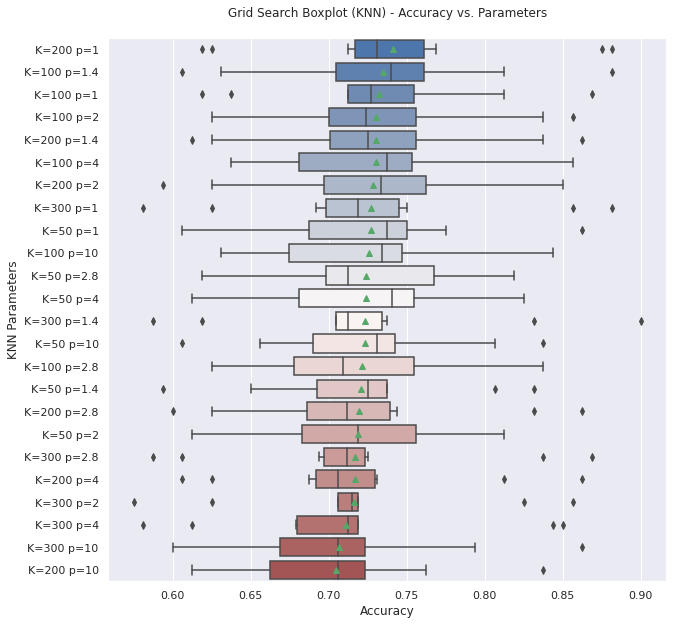

In [ ]:
all_scores = []
for i in range(10): 
    key = 'split'+str(i)+'_test_score'
    all_scores.append(clf.cv_results_[key])

# Add back the column names
col_names = []
for i in n_list: 
    for j in p_list:
        col_names.append("K=" +str(i)+' p='+str(j))


# Add column names to a dataframe
df_boxplot = pd.DataFrame(all_scores,columns=col_names)

# Use df_boxplot to create our plot
plt.figure(figsize=(10,10))

plt.title('Grid Search Boxplot (KNN) - Accuracy vs. Parameters\n')

df_boxplot = pd.DataFrame(df_boxplot).melt()

df_boxplot.columns = ['KNN Parameters','Accuracy']
df_boxplot['mean_col'] = df_boxplot.groupby('KNN Parameters').transform(np.mean)  
df_boxplot = df_boxplot.sort_values('mean_col',ascending=False)
df_boxplot.drop('mean_col',axis=1,inplace=True)

sns.boxplot(y='KNN Parameters' , x='Accuracy',data = df_boxplot, showmeans=True,palette='vlag', orient='h');



**Q** What are the optimal hyperparameter values, and why? Does this surprise you?

**A** 

### [Decision Tree Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

We are now going to find the optimal tree depth for our decision tree classifier using grid search and 10-fold cross-validation. We will use **pruning**, which reduces the size of decision trees by removing sections of the tree that are non-critical and redundant to classify instances. Pruning reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.

One of the questions that arises in a decision tree algorithm is the optimal size of the final tree. A tree that is too large risks overfitting the training data and poorly generalizing to new samples. A small tree might not capture important structural information about the sample space. However, it is hard to tell when a tree algorithm should stop because it is impossible to tell if the addition of a single extra node will dramatically decrease error. A common strategy is to grow the tree until each node contains a small number of instances then use pruning to remove nodes that do not provide additional information. ([Source](https://en.wikipedia.org/wiki/Decision_tree_pruning))

In our case, since our data is relatively small, we will train different decision tree models by varying their maximum depth.  

In [ ]:
# We change the maximum tree depth (max_depth) using 10-fold cross validation.
scores = []

# Check tree depths in the range [2, 20]
for depth in np.arange(2,21):
    # Initialize the decision tree
    dt_clf = DecisionTreeClassifier(max_depth=depth, random_state=10)

    # We are using the cross_val_score() function for 10-fold CV
    # The default scoring metric is accuracy
    score_list = cross_val_score(dt_clf, X, Y, cv=10)  
    scores.append(score_list)


---
**Q** What are the reasons to prune a decision tree in terms of the bias-variance tradeoff?

**A** 

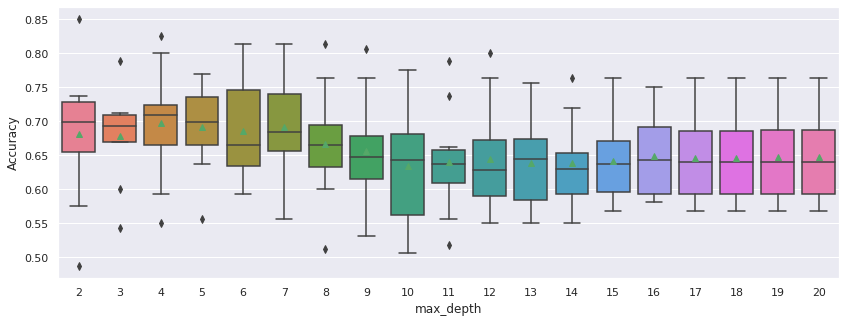

In [ ]:
# Draw box and whisker plots of the accuracy scores for each tree depth
# https://seaborn.pydata.org/generated/seaborn.boxplot.html 
# Plot shows median (line), mean (triangle), and quartiles (box, 25%/50%)
# Whiskers show extent of the data distribution, dark dots (diamonds) show outliers
plt.figure(figsize=(14,5))
df_boxplot = pd.DataFrame(scores).T.melt()
df_boxplot.columns = ['max_depth','Accuracy']
df_boxplot['max_depth'] = (df_boxplot['max_depth']+2)
sns.boxplot(x='max_depth' , y='Accuracy',data = df_boxplot, showmeans=True,palette='husl');

In [ ]:
# Print the values for mean accuracy and std_dev as well
tree_scores = pd.DataFrame([np.arange(2,21), np.mean(scores,axis=1), np.std(scores,axis=1)]).T
tree_scores.columns = ['max_depth', 'accuracy', 'std_dev']
tree_scores.sort_values('max_depth',ascending=True).iloc[0:20,]

,max_depth,accuracy,std_dev
0,2.0,0.681678,0.093006
1,3.0,0.677932,0.062906
2,4.0,0.696694,0.079035
3,5.0,0.691686,0.060512
4,6.0,0.685401,0.072807
5,7.0,0.691061,0.075043
6,8.0,0.666034,0.078850
7,9.0,0.656651,0.077271
8,10.0,0.634764,0.082390
9,11.0,0.640385,0.074302


**Q** What optimal tree depth would you choose, and why? Is there anything that surprises you about the plot and data?

**A** 



-----
**Q** What effect on these results would a small change in training data have?

**A** 

## Effects of Optimal Hyperparameters

You are now going to look at the effects of hyperparameter tuning on the error metrics and plots you created so far. From this point on we are only going to consider the SVM, kNN, and decision tree models.

---
**Q** In your solutions Google doc, collect all of the error metrics (accuracy, F1) and plots (confusion matrix, ROC curves, P-R curves) for the different classification models **before and after** hyperparameter tuning by following these steps:

**Before:** Create a title called "Before Hyperparameter Tuning" in your Google doc.
- Go back to the "Basic ML Models" at the beginning of the notebook 
- Capture the hyperparameters for each model by copy / pasting their initialization code (one line) into the Google doc
- Save all of the error metrics and plots *before* "Cross-Validation and Grid Search"
- Write down the optimal hyperparamters for each model *after* "Cross-Validation and Grid Search"

**After:** Create a title called "After Hyperparameter Tuning" in your Google doc.
- Go back to the "Basic ML Models" and change the hyperparameters of each model to their optimal values
- Capture the new hyperparameters for each model by copy / pasting their initialization code (one line) into the Google doc
- Re-run the code to train each model in "Basic ML Models"
- Re-run the "Model Error Metrics" part of the notebook and capture the new error metrics and plots in your Google doc

How did the error metrics and plots change for each model? Describe the changes in a short paragraph in your Google doc. It may be easier to put the respective plots next to each other for comparison. Make sure to clearly label everything.

**A** Put your answers into a solutions Google doc.


# Advanced Topics

## Feature Importance (Decision Tree Example)

So far, we have used all of our features in the dataset for wine quality classification. However, as you noticed during EDA in Part 1, not all features are equally important. We can compute the **feature importance** for all our features. 

Feature importance refers to techniques that assign a score to input features based on how useful they are at predicting a target variable. There are many types and sources of feature importance scores. Popular examples include statistical correlation scores, coefficients calculated as part of linear models and decision trees, and permutation importance scores. See [this blog post](https://machinelearningmastery.com/calculate-feature-importance-with-python/) for more information and how to compute feature importance metrics in scikit-learn. 

In this example, we are going to use the function `compute_feature_importances()` by the `DecisionTreeClassifier()`. The higher the score, the more important the feature.

In [ ]:
# Fit a new decision tree classifier
dt_clf = DecisionTreeClassifier(random_state=10, max_depth=5)
dt_clf.fit(X, Y)

# Capture the feature importance scores returned by compute_feature_importances()
feat_importance = dt_clf.tree_.compute_feature_importances()

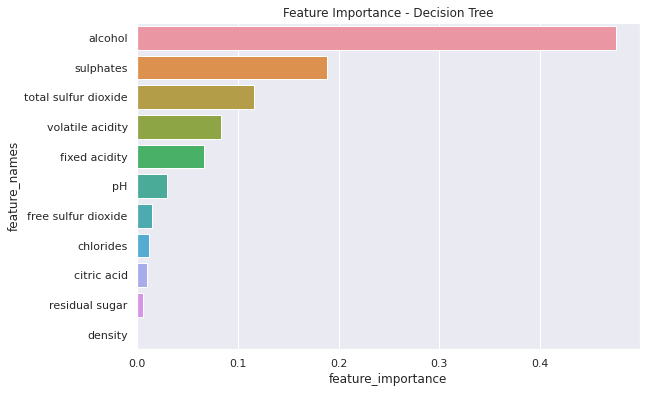

In [ ]:
# Create a dataframe to tabulate the importance scores for each of our features
df_imp = pd.DataFrame({'feature_importance':feat_importance, 'feature_names': X.columns}).sort_values('feature_importance',ascending=False)

# Plot them in a bar chart
fig, ax = plt.subplots(figsize=(9,6))
sns.barplot(y='feature_names', x='feature_importance',data=df_imp, orient='h',ax=ax);
ax.set_title('Feature Importance - Decision Tree');


**Q** Which features are most important for the classification of wine quality using a decision tree model?

**A** 

## Visualizing Decision Boundaries

Lastly, we may want to get a better handle on what our decision boundaries look like. Unfortunately, using all of our eight features means that the decision boundary lives in an eight-dimensional hyperspace. To visualize higher-dimensional spaces we would need a dimensionality reduction method to project the samples into 2D. This could be done in scikit-learn using a linear method such as [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca#sklearn.decomposition.PCA) or a non-linear method such as [Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html).

Instead of using dimensionality reduction, we will train a new decision tree on the `alcohol` and `sulphates` features. We can then visualize the decision boundary in that two-dimensional feature space. 

In [ ]:
# We first define the plotting function for decision boundaries for the wine data
def plot_wine_2d_boundaries(X_data, y_data, predictors, model, xx_1, xx_2):
    """Plots 2-dimensional decision boundaries for a fitted sklearn model
    
    :param X_data: pd.DataFrame object containing your predictor variables
    :param y_data: pd.Series object containing your response variable
    :param predictors: list of predictor names corresponding with X_data columns
    :param model: sklearn fitted model object
    :param xx_1: np.array object of 2-dimensions, generated using np.meshgrid
    :param xx_2: np.array object of 2-dimensions, generated using np.meshgrid
    """

    def plot_points(ax):
        for i, y_class in enumerate(set(y_data.flatten())):
            index = (y_data == y_class)
            ax.scatter(
                X_data[index][predictors[0]],
                X_data[index][predictors[1]],
                c=colors[i],
                marker=markers[i],
                s=65, 
                edgecolor='w',
                label="class {}".format(i),
            )
    colors = ["tab:blue", "tab:orange"] # Add more colors for more than 2 classes here
    markers = ["s", "o", "D"]

    # Plotting decision regions
    f, ax = plt.subplots(1, 1, figsize=(7, 6))

    X_mesh = np.stack((xx_1.ravel(), xx_2.ravel()), axis=1)

    Z = model.predict_proba(X_mesh)[:,1]
    Z = Z.reshape(xx_1.shape)

    ax.contourf(xx_1, xx_2, Z, alpha=0.3, colors=colors, levels=2)

    plot_points(ax)

    ax.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)

    ax.set_title(
        'Wine  class prediction\nDecision boundaries',
        fontsize=16
    )
    ax.set_xlabel(predictors[0], fontsize=12)
    ax.set_ylabel(predictors[1], fontsize=12)

    plt.tight_layout()
    plt.show()

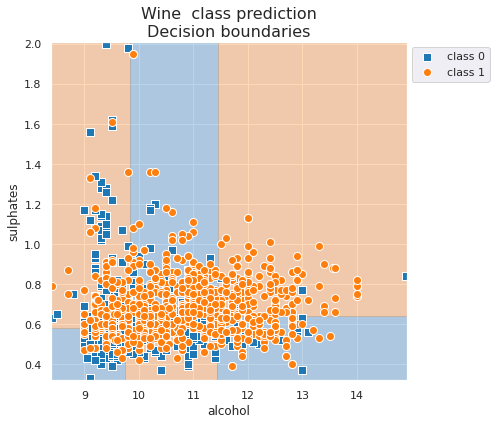

In [ ]:
# Model fit on just two features - alcohol, sulphates - since we can only 
# visualize two features in the 2D plot
predictors = ['alcohol','sulphates']  

# You will explore different models by uncommenting one of these lines
model1 = DecisionTreeClassifier(max_depth=3, random_state=10).fit(X[predictors],Y)   
# model1 = SVC(kernel='rbf', C=10, probability=1, random_state=10).fit(X[predictors], Y)  
# model1 = LogisticRegression(C=10000, random_state=10).fit(X[predictors],Y)   

# Identify appropriate boundaries for our meshgrid by
# referencing the actual wine data
x_1_wine = X['alcohol']     
x_2_wine = X['sulphates']  
alpha = 0.01 #0.1
x_1_min_wine, x_1_max_wine = x_1_wine.min() - alpha, x_1_wine.max() + alpha
x_2_min_wine, x_2_max_wine = x_2_wine.min() - alpha, x_2_wine.max() + alpha

# Use np.arange to generate our interval arrays
# and np.meshgrid to generate our actual grids
xx_1_wine, xx_2_wine = np.meshgrid(
    np.arange(x_1_min_wine, x_1_max_wine, 0.003),
    np.arange(x_2_min_wine, x_2_max_wine, 0.003)
)

# Now we have everything we need to generate our plot
plot_wine_2d_boundaries(
    X,  
    Y,
    predictors,
    model1,
    xx_1_wine,
    xx_2_wine,
)

**Q** Change the model from decision tree to KNN, SVM, and logistic regression by uncommenting code in lines 6-9 above. For each model, change the models hyperparameters to find values that create optimal decision boundaries. Note that each run may take some time for the SVM model. 

Save the images of the optimal decision boundaries for each model and put them in your solutions document. Label each with the name of the model and the optimal hyperparameters. Below each plot describe why you chose these particular hyperparameter values.

**A** Put your answers into a solutions Google doc.

-----
**Q** Looking at these decision boundaries, which model is optimal, and why?

**A** 

---
**Please make sure to finish all of the parts above before you change to imbalanced data in the next section.** 

## Balanced vs. Imbalanced Data

To demonstrate the difference between error metrics you will re-run these measures for imbalanced training and test data with more negative examples (class 0). In your solutions Google doc, collect all of the error metrics (accuracy, F1) and plots (confusion matrix, ROC curves, P-R curves) for the different classification models **before and after** making the data imbalanced by following these steps:

**Before:** Create a title called "Before Data Imbalance" in your Google doc.
- Go back to the "Binary Classification" at the beginning of the notebook 
- Capture the ratio of negative (class 0) to positive (class 1) examples in your Google doc
- Capture the error metrics and plots in your Google doc. You already did this for the "Effects of Optimal Hyperparameter" exercise above. Copy those results here for easier comparison.  

**After:** Create a title called "After Data Imbalance" in your Google doc.
- Go back to "COME BACK HERE" in the "Binary Classification" section at the beginning of the notebook.
- Change the binary classification to make the dataset imbalanced.
- Capture the ratio of negative (class 0) to positive (class 1) examples in your Google doc
- Re-run the code to train each model in "Basic ML Models"
- Re-run the "Model Error Metrics" part of the notebook and capture the new error metrics and plots in your Google doc

How did the error metrics and plots change for each model? Describe the changes in a short paragraph in your Google doc. It may be easier to put the respective plots next to each other for comparison. Make sure to clearly label everything.

**A** Put your answers into a solutions Google doc.

___
**Q** Which error metrics perform better in showing the difference between balanced and imbalanced classes? Which ones do not show a difference? 

**A** 

---
**Q** Based on this example, why does imbalanced data pose a danger for machine learning models?

**A** 

## Handling Imbalanced Data

Since it happens quite often that the minority class has much less data (e.g., in health care applications) we need to know how to handle imbalanced data. We are going to continue with our example of imbalanced data between good quality (class 1) wines and the rest (class 0), so make sure you completed the previous exercise to create imbalanced data and rerunning the code cells. 

### Penalized SVM

The first approach is to use a **penalized** model that uses penalized learning algorithms to increase the cost of classification mistakes on the minority class. We will use penalized SVM, a popular algorithm for this technique, that uses class weights to penalize the majority class.

In [ ]:
# From Part 1
# Creating the SVM model
# We are setting probability=True for the model to predict probabilites (this was not in part 1)
# Note the hyperparameters 'kernel' and 'C' - we will come back to these later
# class_weight is the parameter that helps with class imbalance 
svc_clf = SVC( kernel='rbf', random_state=10, C=1.0, probability=True, class_weight='balanced') 

# Fitting the model to the data (i.e., training the model)
svc_clf.fit(X_train_s, y_train) 

# Predictions on the test set
svc_preds = svc_clf.predict(X_test_s)

# Predict probabilities on the test set
# Predicted probabilites are required for plotting ROC AUC curve
svc_preds_prob = svc_clf.predict_proba(X_test_s)

print(color.BLUE + '\nPenalized SVM: ')
print("Accuracy:", accuracy_score(y_test,svc_preds))
print("F1-Score: {0:0.5f}".format(f1_score(y_test,svc_preds)))



Penalized SVM: 
Accuracy: 0.765625
F1-Score: 0.78134


**Q** What are the different accuracy and F1 scores for the SVM model with and without class weights ? 

**A** 

### Minority Upsampling

Our second, more general approach is to balance our data using upsampling of the minority class. **Upsampling** is the process of randomly duplicating observations from a class in order to reinforce its signal. There are several heuristics for doing so, but the most common way is to simply resample with replacement. 

In [ ]:
# We first upsample our minority class
from sklearn.utils import resample

# Separate majority and minority classes
X['target'] = Y
df_majority = X[Y==0]
df_minority = X[Y==1]

print("Current Ratio:\n", pd.Series(Y).value_counts())

print("\nMajority and Minority Dataframe shapes: ",df_majority.shape, df_minority.shape, "\n")

# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])

print("New ratio:\n",df_upsampled.target.value_counts())

Current Ratio:
 1    855
0    744
dtype: int64

Majority and Minority Dataframe shapes:  (744, 12) (855, 12) 

New ratio:
 1    744
0    744
Name: target, dtype: int64


In [ ]:

target_upsampled = df_upsampled['target']
df_upsampled.drop('target', axis=1, inplace=True)

In [ ]:
# From Part 1 - Standardize the data
# Split data into train (80%) and test (20%) sets.
# random_state: Controls the shuffling applied to the data before applying the split. 
#              Pass an int for reproducible output across multiple function calls.
X_train_upsampled, X_test_upsampled, y_train_upsampled, y_test_upsampled = train_test_split(df_upsampled, target_upsampled,
                                                    test_size=0.2,
                                                    random_state=10)


# Standardize the features

# We standardize training and test data separately to avoid information leakage between them
# Also note we do not standardize the predicted value `quality`, just the features
scaler = StandardScaler()
X_train_upsampled_std = scaler.fit_transform(X_train_upsampled)
X_test_upsampled_std = scaler.transform(X_test_upsampled)

# sklearn StandardScaler() returns Numpy arrays. That means your column names are gone. 
# If we want to preserve the column names we need to convert the array back to a Pandas dataframe and add the column names. 
X_train_upsampled_std = pd.DataFrame(X_train_upsampled_std,columns=df_upsampled.columns)
X_test_upsampled_std = pd.DataFrame(X_test_upsampled_std,columns=df_upsampled.columns)

In [ ]:
# Now we are going to use the the df_upsampled dataset to create the SVM model 
svc_clf = SVC( kernel='rbf', random_state=10, C=1.0, probability=True, class_weight='balanced') 

# Fitting the model to the data (i.e., training the model)
svc_clf.fit(X_train_upsampled_std, y_train_upsampled) 

# Predictions on the test set
svc_preds = svc_clf.predict(X_test_upsampled_std)

# Predict probabilities on the test set
# Predicted probabilites are required for plotting ROC AUC curve
svc_preds_prob = svc_clf.predict_proba(X_test_upsampled_std)

print(color.BLUE + '\nSupport Vector Machine: ')
print("Accuracy:", accuracy_score(y_test_upsampled,svc_preds))

#SVM with no class weight results - accuracy 
#Support Vector Machine: 
#Accuracy: 0.871875

#SVM with no class weight - f1 score
print(color.BLUE + '\nSupport Vector Machine: ')
print("F1-Score: {0:0.5f}".format(f1_score(y_test_upsampled,svc_preds)))

# Support Vector Machine: 
# F1-Score: 0.38806


Support Vector Machine: 
Accuracy: 0.7718120805369127

Support Vector Machine: 
F1-Score: 0.77181


**Q** Summarize the accuracy and F1 score results here and discuss what method to deal with the imbalanced data worked best.

**A** 

---

Congratulations, you have made it to the end of this notebook. This concludes our wine classification example. We hope it was instructive and that you learned some valuable lessons for your final projects. Do not hesitate to ask questions about the code on EdStem or in TF office hours.